# Model Selection & Underfitting & Overfitting

Polynomial regression

In [13]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### Data Generation

$y=5+1.2x-3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!}+\epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1^2)$.

In [14]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [15]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) 
    for x in [true_w, features, poly_features, labels]]

# View the first two samples
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.5734],
         [ 1.1988]]),
 tensor([[ 1.0000e+00, -1.5734e+00,  1.2378e+00, -6.4917e-01,  2.5535e-01,
          -8.0352e-02,  2.1071e-02, -4.7361e-03,  9.3147e-04, -1.6284e-04,
           2.5621e-05, -3.6647e-06,  4.8050e-07, -5.8155e-08,  6.5358e-09,
          -6.8555e-10,  6.7415e-11, -6.2394e-12,  5.4539e-13, -4.5164e-14],
         [ 1.0000e+00,  1.1988e+00,  7.1854e-01,  2.8713e-01,  8.6050e-02,
           2.0631e-02,  4.1220e-03,  7.0592e-04,  1.0578e-04,  1.4090e-05,
           1.6891e-06,  1.8407e-07,  1.8389e-08,  1.6957e-09,  1.4520e-10,
           1.1604e-11,  8.6943e-13,  6.1309e-14,  4.0831e-15,  2.5762e-16]]),
 tensor([-4.7157,  5.8229]))

### Evaluate Models

In [16]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1] # average loss

## Training

In [17]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

**3 order polynomial regression**

weight: [[ 4.9915586  1.2415733 -3.3736665  5.543915 ]]


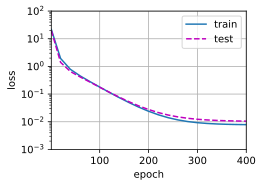

In [18]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

The learned weights are close to the real  weigths [5, 1.2, -3.4, 5.6].

**Underfitting**

weight: [[3.8749485 3.0997002]]


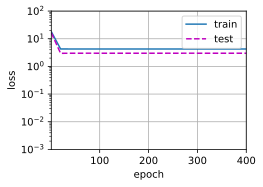

In [19]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

It can be seen that after 400 epochs, there is still a gap betwen training and testing, which indicates underfitting.

**Overfitting**

weight: [[ 4.9861193   1.3104386  -3.3013113   5.1215906  -0.2938026   1.3970095
   0.16226521  0.35951394  0.04967575 -0.16418117 -0.01019958 -0.03753234
  -0.17728269  0.02813699 -0.12091154  0.06001676 -0.05985418 -0.12555742
  -0.10045487  0.0737159 ]]


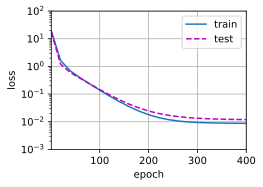

In [20]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

It can be seen that as learning progress, the gap between traing and testing are very small at first and then increases, which indicates overfitting.